# SageMaker DeepAR

<a href='https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html'>Amazon SageMaker DeepAR</a> is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks (RNN). Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit one model to each individual time series, and then use that model to extrapolate the time series into the future. In many applications, however, you might have many similar time series across a set of cross-sectional units (for example, demand for different products, load of servers, requests for web pages, and so on). In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR takes this approach, training a model for predicting a time series over a large set of (related) time series.

Technical details can be found in this <a href='https://arxiv.org/pdf/1704.04110.pdf'>arXiv paper</a>.

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../_datasets/daily-exchange-rates.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(7588, 8)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8
DateTime,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


## Define Parameters

Make predictions for four-week period using a training period of one year. DeepAR will be trained across the whole dataset (excluding the test period).

In [4]:
dataset_name = 'Daily Exchange Rates'
dataset_abbr = 'DER'
model_name = 'ARIMA'
context_length = 52*5 # 52 weeks
prediction_length = 4*5 # 4 weeks
prediction_length = (df.index[-1] - df.index[-prediction_length]).days # Predict non-working days too
freq = 'D'

## Configure S3 Storage and Container

In [5]:
bucket = '<your_bucket_name_here>'
prefix = 'sagemaker/deepar/%s' % dataset_abbr

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, the container image is configured to be use the appropriate region.

In [6]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-1': '633353088612.dkr.ecr.ap-northeast-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-2': '204372634319.dkr.ecr.ap-northeast-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [7]:
def calc_MASE(training_series, testing_series, prediction_series):
    a = training_series.iloc[1:].values
    b = training_series.iloc[:-1].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Prepare Data for SageMaker

Extract time series and set aside data for testing.

In [8]:
time_series = []
for k in df.columns:
    time_series.append(df[k])
    
time_series_training = []
for ts in df.columns:
    time_series_training.append(df.iloc[:-prediction_length][ts])

Visualise time series example.

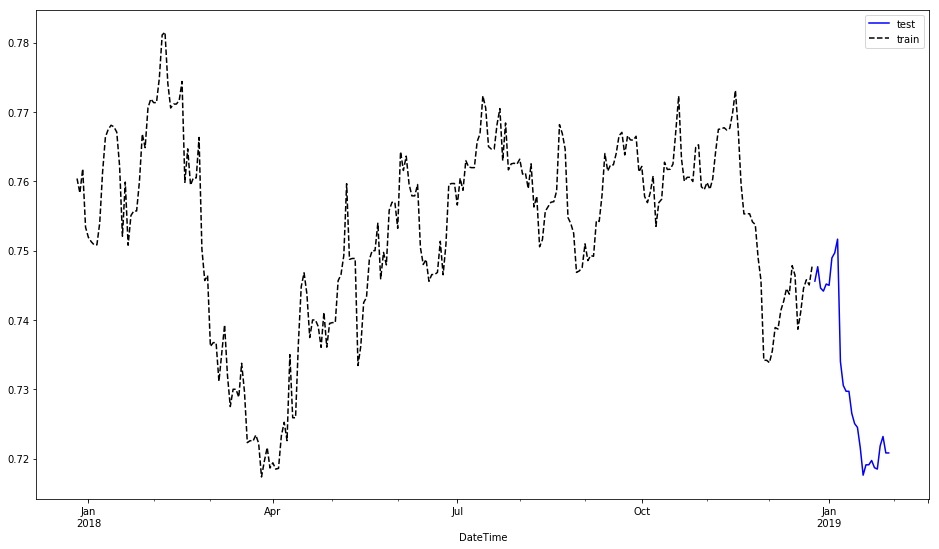

In [9]:
time_series[0][-prediction_length:].plot(label='test', figsize=(16, 9), c='b')
time_series_training[0][-context_length:].plot(label='train', c='k', linestyle='--')
plt.legend()
plt.show()

Convert time series into JSON strings for DeepAR.

In [10]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [11]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

## Train Model

Define the estimator for training and set hyperparameters.

In [12]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.8xlarge',
    base_job_name='%s-deepar' % dataset_abbr,
    output_path="s3://" + s3_output_path
)

In [13]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [14]:
estimator.set_hyperparameters(**hyperparameters)

Launch training job.

In [15]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DER-deepar-2019-03-11-20-19-01-351


2019-03-11 20:19:01 Starting - Starting the training job...
2019-03-11 20:19:02 Starting - Launching requested ML instances......
2019-03-11 20:20:04 Starting - Preparing the instances for training......
2019-03-11 20:21:22 Downloading - Downloading input data
2019-03-11 20:21:22 Training - Downloading the training image..
Arguments: train
[03/11/2019 20:21:43 INFO 140409532397376] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[03/11/2019 20:21:43 INFO 14040

[03/11/2019 20:22:30 INFO 140409532397376] Epoch[3] Batch[10] avg_epoch_loss=-2.159949
[03/11/2019 20:22:30 INFO 140409532397376] Epoch[3] Batch [10]#011Speed: 57.60 samples/sec#011loss=-2.294008
[03/11/2019 20:22:30 INFO 140409532397376] processed a total of 351 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6267.728090286255, "sum": 6267.728090286255, "min": 6267.728090286255}}, "EndTime": 1552335750.608439, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552335744.340643}

[03/11/2019 20:22:30 INFO 140409532397376] #throughput_metric: host=algo-1, train throughput=56.0000815542 records/second
[03/11/2019 20:22:30 INFO 140409532397376] #progress_metric: host=algo-1, completed 20 % of epochs
[03/11/2019 20:22:30 INFO 140409532397376] loss did not improve
[03/11/2019 20:22:31 INFO 140409532397376] Epoch[4] Batch[0] avg_epoch_loss=-2.335395
[03/11/2019 20:22:34 INFO 140409532397376] Epoch[4] Batch[5] avg_epoch_loss=-

[03/11/2019 20:23:07 INFO 140409532397376] Epoch[9] Batch[10] avg_epoch_loss=-2.907051
[03/11/2019 20:23:07 INFO 140409532397376] Epoch[9] Batch [10]#011Speed: 58.03 samples/sec#011loss=-3.042865
[03/11/2019 20:23:07 INFO 140409532397376] processed a total of 331 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6198.203086853027, "sum": 6198.203086853027, "min": 6198.203086853027}}, "EndTime": 1552335787.712838, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552335781.514581}

[03/11/2019 20:23:07 INFO 140409532397376] #throughput_metric: host=algo-1, train throughput=53.4016087166 records/second
[03/11/2019 20:23:07 INFO 140409532397376] #progress_metric: host=algo-1, completed 50 % of epochs
[03/11/2019 20:23:07 INFO 140409532397376] best epoch loss so far
[03/11/2019 20:23:07 INFO 140409532397376] Saved checkpoint to "/opt/ml/model/state_39fcb0c3-aa3a-4888-a4ca-3eea2cf6b27a-0000.params"
#metrics {"Metrics": {"stat

[03/11/2019 20:23:52 INFO 140409532397376] Epoch[17] Batch[5] avg_epoch_loss=-3.220497
[03/11/2019 20:23:52 INFO 140409532397376] Epoch[17] Batch [5]#011Speed: 57.82 samples/sec#011loss=-3.220497
[03/11/2019 20:23:55 INFO 140409532397376] Epoch[17] Batch[10] avg_epoch_loss=-3.180904
[03/11/2019 20:23:55 INFO 140409532397376] Epoch[17] Batch [10]#011Speed: 58.08 samples/sec#011loss=-3.133392
[03/11/2019 20:23:55 INFO 140409532397376] processed a total of 338 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6218.808889389038, "sum": 6218.808889389038, "min": 6218.808889389038}}, "EndTime": 1552335835.021795, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552335828.802929}

[03/11/2019 20:23:55 INFO 140409532397376] #throughput_metric: host=algo-1, train throughput=54.3502376816 records/second
[03/11/2019 20:23:55 INFO 140409532397376] #progress_metric: host=algo-1, completed 90 % of epochs
[03/11/2019 20:23:55 INFO 140


2019-03-11 20:24:23 Uploading - Uploading generated training model
2019-03-11 20:24:23 Completed - Training job completed
Billable seconds: 195


## Create Endpoint and Predictor

In [16]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DER-deepar-2019-03-11-20-19-01-351
INFO:sagemaker:Creating endpoint-config with name DER-deepar-2019-03-11-20-19-01-351
INFO:sagemaker:Creating endpoint with name DER-deepar-2019-03-11-20-19-01-351


---------------------------------------------------------------------------!

Create utility class to make predictions from Pandas Series.

In [17]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [(x.index[-1].to_period(self.freq)+1).to_timestamp() for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [18]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make Predictions

In [19]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series

In [20]:
tic = time.time()
for i in range(5, len(time_series), 5):
    toc = time.time()
    print("Running predictions for time series {} to {}... (cumulative time: {:.1f}s.)".format(
        i+1, min(i+5, len(time_series))+1, toc-tic))
    pred = predictor.predict(time_series_training[i:(i+5)])
    list_of_df = list_of_df + pred

Running predictions for time series 6 to 9... (cumulative time: 0.0s.)


Show some example forecasts.

In [50]:
results = []
for i in range(len(actual_data)):
    results.append(pd.concat([actual_data[i], list_of_df[i]], axis=1))
    results[i].dropna(inplace=True)

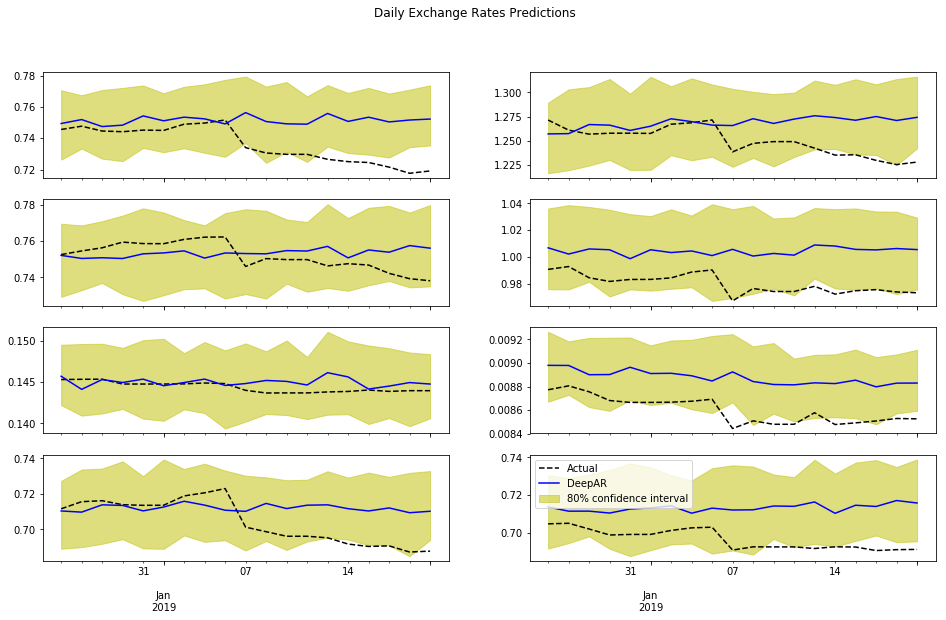

In [51]:
fig, ax = plt.subplots(4, 2, sharex=True)
ax = ax.ravel()

for k in range(8):
    results[k]['ts%s' % (k+1)].plot(label='Actual', c='k', linestyle='--', ax=ax[k])
    p10 = results[k]['0.1']
    p90 = results[k]['0.9']
    ax[k].fill_between(p10.index, p10, p90, color='y', alpha=0.5,
                         label='80% confidence interval')
    results[k]['0.5'].plot(label='DeepAR', c='b', ax=ax[k])
ax[-1].legend()
fig.suptitle('{} Predictions'.format(dataset_name))
plt.show()

## Evaluate DeepAR

In [53]:
results[0].head(10)

,ts1,0.1,0.5,0.9
2018-12-25,0.745601,0.726368,0.749407,0.770618
2018-12-26,0.747680,0.733365,0.751913,0.767442
2018-12-27,0.744602,0.726970,0.747458,0.770795
2018-12-28,0.744158,0.725383,0.748354,0.772128
2018-12-31,0.745184,0.733805,0.754243,0.773705
2019-01-01,0.744990,0.731078,0.751134,0.768740
2019-01-02,0.748951,0.733568,0.753451,0.772888
2019-01-03,0.749681,0.730709,0.752365,0.774462
2019-01-04,0.751654,0.728139,0.749141,0.777284
2019-01-07,0.733999,0.736947,0.756365,0.779351


In [57]:
MASEs = []
for i, col in enumerate(df.columns):
    MASEs.append(calc_MASE(actual_data[i].iloc[-(context_length+len(results[i])):-len(results[i])],
                           results[i]['ts%s' % (i+1)],
                           results[i]['0.5']))

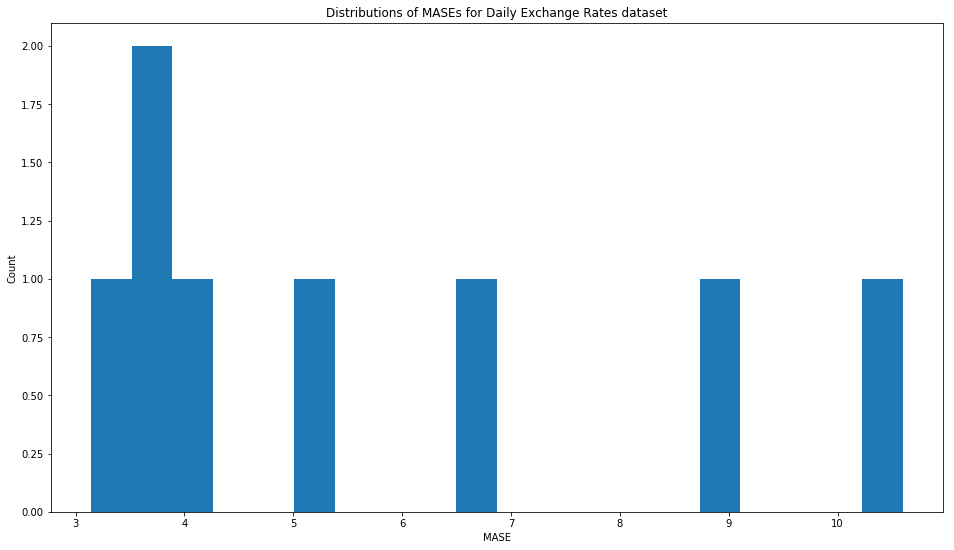

In [58]:
fig, ax = plt.subplots()
ax.hist(MASEs, bins=20)
ax.set_title('Distributions of MASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('MASE')
ax.set_ylabel('Count');

In [59]:
MASE = np.mean(MASEs)
print("Overall MASE: {:.4f}".format(MASE))

Overall MASE: 5.7467


Store the predictions and accuracy score for the DeepAR model.

In [67]:
full_results = results[0][['ts1', '0.5']]
full_results.columns = ['ts1', 'ts1_pred']
for i in range(len(results))[1:]:
    full_results['ts%s' % (i+1)] = results[i]['ts%s' % (i+1)]
    full_results['ts%s_pred' % (i+1)] = results[i]['0.5']
full_results.head()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ts1,ts1_pred,ts2,ts2_pred,ts3,ts3_pred,ts4,ts4_pred,ts5,ts5_pred,ts6,ts6_pred,ts7,ts7_pred,ts8,ts8_pred
2018-12-25,0.745601,0.749407,1.271375,1.256981,0.752615,0.752156,0.990688,1.006816,0.145307,0.145706,0.008773,0.008979,0.711592,0.710371,0.704722,0.713658
2018-12-26,0.747680,0.751913,1.260923,1.257289,0.754623,0.750460,0.992812,1.002160,0.145338,0.144121,0.008806,0.008979,0.715615,0.709704,0.705015,0.711440
2018-12-27,0.744602,0.747458,1.256755,1.266699,0.756370,0.750844,0.984417,1.005977,0.145351,0.145307,0.008756,0.008900,0.716153,0.713833,0.701971,0.711455
2018-12-28,0.744158,0.748354,1.257703,1.266101,0.759512,0.750434,0.981691,1.005366,0.144766,0.144949,0.008682,0.008902,0.713903,0.713483,0.698800,0.710440
2018-12-31,0.745184,0.754243,1.257743,1.260615,0.758708,0.753018,0.983158,0.998690,0.144766,0.145358,0.008666,0.008963,0.713547,0.710419,0.699088,0.712592


In [68]:
import pickle
    
with open('{}-MASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(MASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(full_results, f)

## Delete Endpoint

In [28]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DER-deepar-2019-03-11-20-19-01-351
